<a href="https://colab.research.google.com/github/ianmessa/appm-4600-numerics/blob/main/Labs/Lab07_gradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Gradient descent on Rosenbrock


We'll use the very classic Rosenbrock test function; see [wikipedia](https://en.wikipedia.org/wiki/Rosenbrock_function) for a plot of what it looks like in 2D

Learning objectives
- See how to implement gradient descent
- Compare gradient descent and Newton's method for optimization
- Look at alternatives (e.g., alternating minimization/coordinate descent, Nelder Mead, etc.) and see how they compare

We have 4 tasks:
1. Implement gradient descent, and use it to minimize the Rosenbrock function
2. Implement Newton's method (for optimization), and again minimize Rosenbrock
3. Implement alternating minimization for 2D Rosenbrock
4. (Optional) Try some of `scipy.optimize.minimize`'s builtin solvers

**Deliverables**

1. Turn in a PDF showing your implementation of gradient descent and evidence that it works

You do *not* need to turn in the work on the other 3 tasks


APPM 4600. Copyright Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause license

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
from scipy.optimize import rosen, rosen_der, rosen_hess
import scipy.optimize
from matplotlib import colors, cm

# Task 0. Warmup -- investigate the Rosenbrock function

Setup the problem and see how the functions work

In [26]:
n = 2 # pick a dimension. Let's do n=2 for visualization reasons

xSolution = np.ones(n)  # this is a known solution; see wikipedia
errFcn    = lambda x : np.linalg.norm(x - xSolution)

x0 = .1*np.ones(n)

print('Function g(x)', rosen(x0))
print('Gradient of g', rosen_der(x0))
print('Hessian of g')
print(rosen_hess(x0))

Function g(x) 1.62
Gradient of g [-5.4 18. ]
Hessian of g
[[-26. -40.]
 [-40. 200.]]


Plot it...

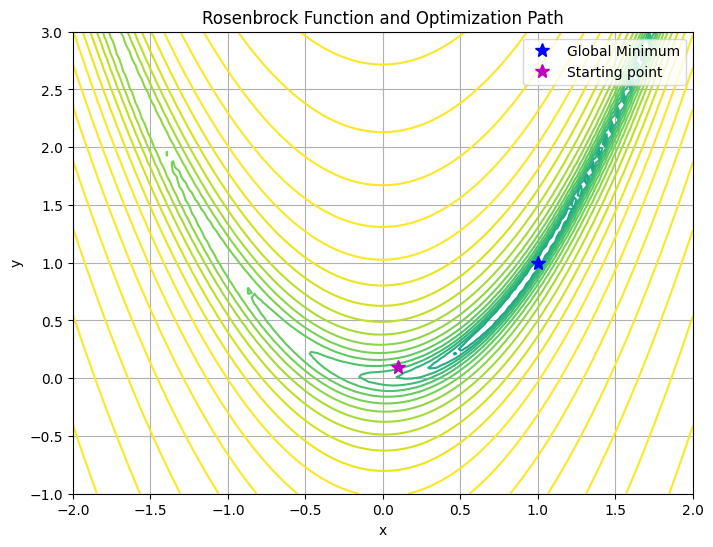

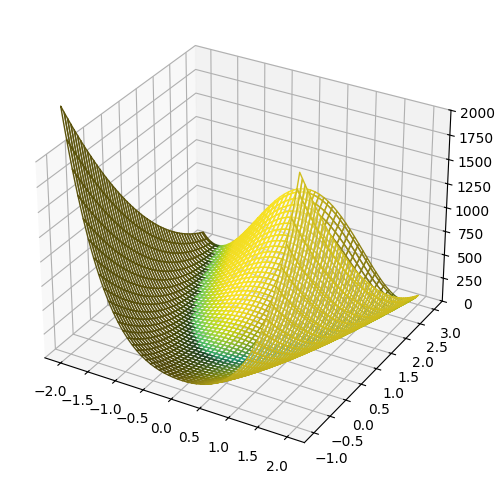

In [27]:
# Create a contour plot of the Rosenbrock function
Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Zgrid = rosen([Xgrid, Ygrid])

plt.figure(figsize=(8, 6))
clr_norm = colors.LogNorm(vmin=Zgrid.min(), vmax=100)
plt.contour(Xgrid, Ygrid, Zgrid, levels=np.logspace(-0.5, 3.5, 20),
            norm=clr_norm )
plt.plot(1,1, 'b*', markersize=10, label='Global Minimum')
plt.plot(x0[0],x0[1], 'm*', markersize=10, label='Starting point')
plt.title('Rosenbrock Function and Optimization Path')
plt.xlabel('x')
plt.ylabel('y')
zoom = False
if zoom:
    plt.xlim(0.05, 1.25)
    plt.ylim(0.05, 1.25)
plt.legend()
plt.grid(True)
plt.show()

# 3D plot
fig, ax = plt.subplots(figsize=(8, 6),subplot_kw={"projection": "3d"})
clrs = cm.viridis(clr_norm(Zgrid))
surf = ax.plot_surface( Xgrid, Ygrid, Zgrid,facecolors=clrs)#,rstride=3,cstride=3)
ax.set_zlim(0, 2000)
surf.set_facecolor((1,1,1,.35))

## Task 1: minimize the Rosenbrock function using gradient descent

Your function should solve a generic problem $$\min_{\vec{x}\in\mathbb{R}^n} g(\vec{x})$$
and take as inputs at least:
1. `g` (code that computes $g(\vec{x})$)
2. `gprime` (code that computes $\nabla g(\vec{x})$)
3. `x0` (a starting guess, of the right size)
4. a stepsize for gradient descent

For this lab, I suggest using a fixed stepsize (determined by trial and error), though if you are ambitious you can try a linesearch.  See [Backtracking line search -- Armijo conditions](https://en.wikipedia.org/wiki/Backtracking_line_search#Algorithm) for a good one (good enough, and easy to code); try $c=10^{-4}$ and $\tau=0.9$ for reasonable values.

Then test your gradient descent code on the Rosenbrock function.
The prebuilt code `rosen` and `rosen_der` compute the function value and gradient of the Rosenbrock function for you.

We know where the true minimum is, so you can check your answer. You should aim to find a solution $\vec{x}$ such that $\|\vec{x} - \vec{x}_\text{true minimum}\|_2 \le 10^{-4}$. How many iterations does this take?

In [ ]:
def gradientDescent(g,gprime,x0,lr,tol):
    x = np.array(x0,copy=True)
    xim1 = x.copy()
    xi = xim1 - gprime(xim1) * lr
    i = 0
    while np.linalg.norm(xi - xim1, ord = 2) > tol:
      xim1 = xi
      xi = xim1 - gprime(xim1) * lr
      plt.scatter(*xim1)
      plt.scatter(*xi)
      i += 1
    return i, xi

my_iters, my_x_star = gradientDescent(rosen, rosen_der, x0, 1e-2, 1e-4)
print(my_iters)
true_x_star = np.ones(2)
print(my_x_star - true_x_star)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fbe73e207c0> (for post_execute):


KeyboardInterrupt: 

## Task 2: minimize the Rosenbrock function using Newton's method for minimization

To minimize $g(\vec{x})$, Newton's method for minimization iterates as follows:
$$\vec{x}^{(k+1)} = \vec{x}^{(k)} - H_k^{-1} \nabla g(\vec{x}^{(k)})$$
where
$$H_k = \nabla^2 g(\vec{x}^{(k)})$$
is the **Hessian** of $g$ (like the second derivative). The prebuilt code `rosen_hess` computes the Hessian of the Rosenbrock function for you.

You should write generic code that takes in `g`, `gprime` and the `Hessian`, then use it to minimize the Rosenbrock function.

You don't need to have a stepsize (i.e., a stepsize of 1 is fine).  You can do a linesearch if you want, but in that case, you should always start at the trial stepsize of 1. In order to get superlinear or quadratic convergence, you need to eventually be using a stepsize of 1.

How many iterations does it take to converge compared to gradient descent?

What are possible downsides of Newton's method (especially if we work in a dimension $n>2$)?

In [47]:
def NewtonForOptimization(g,gprime,Hessian,x0,tol):
    x = np.array(x0,copy=True)
    xim1 = x.copy()
    xi = xim1 - np.linalg.solve(Hessian(xim1), gprime(xim1))
    while np.linalg.norm(xi - xim1, ord = 2) > tol:
      xim1 = xi
      xi = xim1 - np.linalg.solve(Hessian(xim1), gprime(xim1))
    return xi

my_x_star = NewtonForOptimization(rosen, rosen_der, rosen_hess, np.array([1.1, 1.1]), 1e-4)
print(my_x_star, true_x_star)

[1. 1.] [1. 1.]


## Task 3: alternating minimization (i.e., a variant of coordinate descent)
Since we're working in 2D, let's write $\vec{x} = (x,y)$. Then we can write the Rosenbrock function as:
$$g(x,y) = (1-x)^2 + 100( y-x^2 )^2
= 1 - 2x + x^2 + 100( y^2 - 2yx^2 + x^4)$$

If we knew what $y$ is, then we just have a nice 1D polynomial in $x$ and we could minimize that (how? set the derivatives equal to zero and check which of these roots, aka critical points, is the smallest).

Similarly, if we knew $x$, then we could solve for $y$.

This suggests the **alternating minimization** approach: for iterations $k=1,2,\ldots$, we do
$$x_{k+1} = \text{argmin}_x \quad g(x,y_k)$$
$$y_{k+1} = \text{argmin}_y \quad g(x_{k+1},y)$$

In the context of solving linear systems, this is known as *Gauss-Seidel*.

It doesn't always work, or if it does it may not work well, but for many problems it's easy to try.

When should it work well? If $g(x,y) = g_1(x) + g_2(y)$, then it should work in one step! We call this a *separable* problem.  More generally, if the *level sets* of $g$ are nice circles, then the approach should work well.  If the level sets are instead very *elliptical*, it won't work well: we'll have a lot of **zig-zagging**.

Your **task** is to implement alternating minimization to solve Rosenbrock.

In [77]:
# Alternating minimization, for, specialized for n=2 case
from numpy.polynomial import Polynomial
# expects coefficients in order of increasing degree
# i.e., (1, 2, 3) give 1 + 2*x + 3*x**2.
if n != 2:
    raise Exception('Only works for n=2')

x1_coeffs = lambda x2: np.array([-2, 2 - 400 * x2, 0, 400])
x2_coeffs = lambda x1: np.array([-2 * x1 ** 2, 2])
g_sep = lambda x1, x2: 1 - 2 * x1 + x1 ** 2 + 100 * (x2 ** 2 - 2 * x2 * x1 ** 2 + x1 ** 4)

def alt_min_rosen(x_0, g_sep, x1_coeffs, x2_coeffs, tol:float = 1e-8):
  xim1 = x0.copy()
  x1_im1, x2_im1 = xim1

  x1_rts = Polynomial(x1_coeffs(x2_im1)).roots()

  x1_i_idx = np.argmin(g_sep(x1_rts, np.full_like(x1_rts, x2_im1)))
  x1_i = x1_rts[x1_i_idx]

  x2_rts = Polynomial(x2_coeffs(x1_i)).roots()

  x2_i_idx = np.argmin(g_sep(np.full_like(x2_rts, x1_i), x2_rts))
  x2_i = x2_rts[x2_i_idx]

  xi = np.array([x1_i, x2_i])

  xHist = np.array([xim1, xi])

  while np.linalg.norm(xi - xim1, ord = 2) > tol:
    xim1 = xi
    x1_im1, x2_im1 = xim1

    x1_rts = Polynomial(x1_coeffs(x2_im1)).roots()

    x1_i_idx = np.argmin(g_sep(x1_rts, np.full_like(x1_rts, x2_im1)))
    x1_i = x1_rts[x1_i_idx]

    x2_rts = Polynomial(x2_coeffs(x1_i)).roots()

    x2_i_idx = np.argmin(g_sep(np.full_like(x2_rts, x1_i), x2_rts))
    x2_i = x2_rts[x2_i_idx]

    xi = np.array([x1_i, x2_i])

    xHist = np.concat([xHist, xi[None]], axis = 0)

  return xi, xHist


x_star, xHist = alt_min_rosen(np.array([-8., 8.]), g_sep, x1_coeffs, x2_coeffs)


In [78]:
# Here's an example of how the polynomial class works
# Take p(x) = (x-3)(x+2) = x^2 - x - 6, which has roots at -2 and 3
P = Polynomial( [-6,-1,1] )
print( "Roots of the sample polynomial are:", P.roots() )

Roots of the sample polynomial are: [-2.  3.]


Stationary points of this new polynomial are: [-5.30250127e+00  6.24781037e-03  7.54625346e+00]
2 7.546253458444197


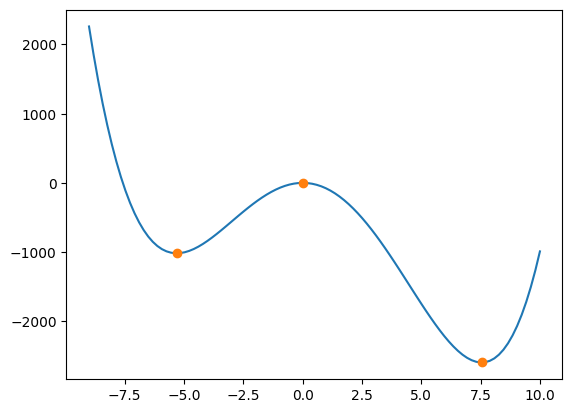

In [79]:
# Let's try another example
P = Polynomial( [1,1,-80,-3, 1] )
rts = P.deriv().roots()
print("Stationary points of this new polynomial are:", rts )

rts_index_of_min = np.argmin( P(rts) ) # np.argmin is useful
print(rts_index_of_min, rts[rts_index_of_min] )

px,py = P.linspace(domain=[-9,10])
plt.plot(px,py)
plt.plot( rts, P(rts), 'o')
plt.show()

If you saved a history vector of all the points (in a variable named `xHist`), then the code below will plot them

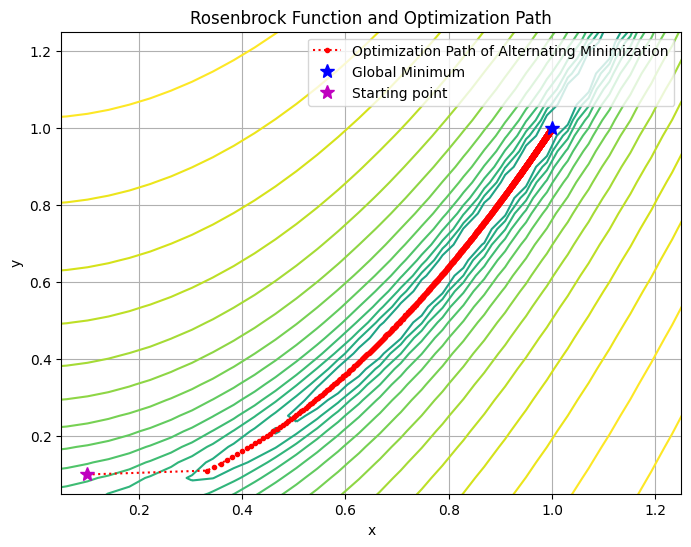

In [80]:
# Create a contour plot of the Rosenbrock function
Xgrid, Ygrid = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-1, 3, 100))
Zgrid = rosen([Xgrid, Ygrid])


plt.figure(figsize=(8, 6))
plt.contour(Xgrid, Ygrid, Zgrid, levels=np.logspace(-0.5, 3.5, 20),
            norm=colors.LogNorm(vmin=Zgrid.min(), vmax=100) )
plt.plot(xHist[:, 0], xHist[:, 1], 'r:', marker='o', \
         markersize=3, label='Optimization Path of Alternating Minimization')
plt.plot(1,1, 'b*', markersize=10, label='Global Minimum')
plt.plot(x0[0],x0[1], 'm*', markersize=10, label='Starting point')
plt.title('Rosenbrock Function and Optimization Path')
plt.xlabel('x')
plt.ylabel('y')
zoom = True
if zoom:
    plt.xlim(0.05, 1.25)
    plt.ylim(0.05, 1.25)
plt.legend()
plt.grid(True)
plt.show()

## Task 4 (optional): try some of the `scipy.optimize` builtin solvers

See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

Some solvers only require function evaluations $g$, others (in fact, most) also require a gradient $\nabla g$, and some (e.g., Newton and variants) also require the Hessian $\nabla^2g$ (or more exactly, they require a function that computes a Hessian-vector-product (HvP): if you give it $\vec{x}$ and $\vec{v}$, the HvP should return $\nabla^2 g(\vec{x})\vec{v}$.

A famous method that only uses $g$ and not $\nabla g$ (so it is "derivative-free") is `Nelder-Mead`. It's famous because it's been around for a long time, not because it is good.  It's also popular because people like the fact that you don't have to give it a derivative/gradient --- it's easier to use!

A prototypical method that requires $g$ and $\nabla g$ is `BFGS` or `L-BFGS-B`, which are **quasi-Newton** methods and generally state-of-the-art.

A method with uses the Hessian is `trust-exact`, which is like Newton's method but adds in a "trust-region" to make it much more robust.

Compare the methods on the Rosenbrock test function in dimension $n=10$

In [ ]:
from time import time
import warnings

n  = 10
x0 = 0.1*np.ones(n)
xSolution = np.ones(n)
errFcn    = lambda x : np.linalg.norm(x - xSolution)

out = scipy.optimize.minimize( ... your code here ... )